In [1]:
import sys
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test
%matplotlib inline
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
from scipy import stats
from scipy.stats import chi2_contingency

In [2]:
import mmrf_data_loader 

In [3]:
patient_list, patients_mask, event_duration, censorlist = mmrf_data_loader.load_MMRF_clinical_data()

659
10
659


In [4]:
clinical_data_df = pd.read_csv('data/km_clinical_data_669.csv')
clinical_data_df = clinical_data_df[clinical_data_df['subjectIDlist'].isin(patient_list)]
clinical_data_df = clinical_data_df.reset_index()

In [5]:
secondary_dataset_df = pd.read_excel('data/MMRF_clin_IA13_to_Anish.xlsx')
columns = ['sample', 'HRD', 't_MMSET', 't_CCND1', 'any_MAF',\
           't_MYC', 'chromothripsis_code', 'APOBEC_code',\
           'TPsum', 'gain1q21']
shorter_id_list = [] 
for id in patient_list: 
    shorter_id_list.append(id[0:14])

secondary_dataset_df = secondary_dataset_df[secondary_dataset_df['sample'].isin(shorter_id_list)]
secondary_dataset_df = secondary_dataset_df.reset_index()
secondary_dataset_df = secondary_dataset_df[columns]

In [6]:
# CPH

In [7]:
short_patient_list = [] 
for id in patient_list: 
    short_patient_list.append(id[0:14])

In [8]:
feature_mask = pd.DataFrame(short_patient_list).isin(secondary_dataset_df['sample'].values) 

In [9]:
feature_mask = feature_mask[0].values

In [10]:
input_label_fn = 'data/WEE1_labels3.csv'
wee1_labels = pd.read_csv(input_label_fn)
wee1_labels = wee1_labels['label'].values

In [11]:
masked_event_duration = event_duration[feature_mask]
masked_censorlist = censorlist[feature_mask]
masked_wee1_mask = wee1_labels[feature_mask]

In [12]:
wee1_labels = wee1_labels[feature_mask]

In [13]:
wee1_labels_mask = wee1_labels==2

In [14]:
wee1_labels_mask = ~wee1_labels_mask

In [15]:
masked_event_duration = masked_event_duration[wee1_labels_mask]
masked_censorlist = masked_censorlist[wee1_labels_mask]
WEE1_labels_masked = masked_wee1_mask[wee1_labels_mask]

In [16]:
secondary_dataset_df = secondary_dataset_df[wee1_labels_mask]

In [17]:
secondary_dataset_df = secondary_dataset_df.reset_index()

In [18]:
secondary_dataset_df.insert(0, 'masked_event_duration', masked_event_duration)
secondary_dataset_df.insert(0, 'masked_censorlist', masked_censorlist)
secondary_dataset_df.insert(0, 'WEE1_labels_masked', WEE1_labels_masked)

In [19]:
secondary_dataset_df = secondary_dataset_df.dropna()

In [20]:
secondary_dataset_df.shape

(489, 14)

In [21]:
secondary_dataset_df.columns

Index(['WEE1_labels_masked', 'masked_censorlist', 'masked_event_duration',
       'index', 'sample', 'HRD', 't_MMSET', 't_CCND1', 'any_MAF', 't_MYC',
       'chromothripsis_code', 'APOBEC_code', 'TPsum', 'gain1q21'],
      dtype='object')

In [22]:
secondary_dataset_df

,WEE1_labels_masked,masked_censorlist,masked_event_duration,index,sample,HRD,t_MMSET,t_CCND1,any_MAF,t_MYC,chromothripsis_code,APOBEC_code,TPsum,gain1q21
0,0,1,1.706849,0,MMRF_1021_1_BM,0.0,1.0,0.0,0,0.0,0,0.0,0.0,1.0
2,1,1,5.435616,2,MMRF_1030_1_BM,1.0,0.0,0.0,0,1.0,0,0.0,0.0,0.0
3,3,1,3.641096,3,MMRF_1031_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,1.0
4,0,1,2.487671,4,MMRF_1032_1_BM,1.0,0.0,0.0,0,0.0,1,0.0,0.0,0.0
6,1,0,0.263014,6,MMRF_1037_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,1,0,0.002740,573,MMRF_2745_1_BM,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
574,3,0,0.424658,574,MMRF_2746_1_BM,0.0,1.0,0.0,0,0.0,0,0.0,0.0,1.0
576,0,0,0.232877,576,MMRF_2751_1_BM,0.0,1.0,0.0,0,0.0,0,0.0,0.0,0.0
577,3,1,0.021918,577,MMRF_2754_1_BM,0.0,0.0,1.0,0,0.0,0,0.0,0.0,1.0


In [23]:
cols_dict = {'WEE1_labels_masked':'WEE1 label', 
       'HRD':'Hyperdiploid', 't_MMSET':'t(4;14)', 't_CCND1':'t(11;14)',\
             'any_MAF':'MAF translocation', 't_MYC':'MYC translocation',\
       'chromothripsis_code':'Chromothripsis', 'APOBEC_code':'Hyper APOBEC',\
             'TPsum':'TP53 aberration', 'gain1q21':'Gain 1q21'}

In [24]:
secondary_dataset_df = secondary_dataset_df.rename(columns=cols_dict) 

In [25]:
secondary_dataset_df.shape

(489, 14)

In [26]:
secondary_dataset_df13 = secondary_dataset_df[secondary_dataset_df['WEE1 label'].isin([1, 3])]

In [27]:
secondary_dataset_df

,WEE1 label,masked_censorlist,masked_event_duration,index,sample,Hyperdiploid,t(4;14),t(11;14),MAF translocation,MYC translocation,Chromothripsis,Hyper APOBEC,TP53 aberration,Gain 1q21
0,0,1,1.706849,0,MMRF_1021_1_BM,0.0,1.0,0.0,0,0.0,0,0.0,0.0,1.0
2,1,1,5.435616,2,MMRF_1030_1_BM,1.0,0.0,0.0,0,1.0,0,0.0,0.0,0.0
3,3,1,3.641096,3,MMRF_1031_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,1.0
4,0,1,2.487671,4,MMRF_1032_1_BM,1.0,0.0,0.0,0,0.0,1,0.0,0.0,0.0
6,1,0,0.263014,6,MMRF_1037_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,1,0,0.002740,573,MMRF_2745_1_BM,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
574,3,0,0.424658,574,MMRF_2746_1_BM,0.0,1.0,0.0,0,0.0,0,0.0,0.0,1.0
576,0,0,0.232877,576,MMRF_2751_1_BM,0.0,1.0,0.0,0,0.0,0,0.0,0.0,0.0
577,3,1,0.021918,577,MMRF_2754_1_BM,0.0,0.0,1.0,0,0.0,0,0.0,0.0,1.0


In [28]:
secondary_dataset_df13

,WEE1 label,masked_censorlist,masked_event_duration,index,sample,Hyperdiploid,t(4;14),t(11;14),MAF translocation,MYC translocation,Chromothripsis,Hyper APOBEC,TP53 aberration,Gain 1q21
2,1,1,5.435616,2,MMRF_1030_1_BM,1.0,0.0,0.0,0,1.0,0,0.0,0.0,0.0
3,3,1,3.641096,3,MMRF_1031_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,1.0
6,1,0,0.263014,6,MMRF_1037_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
9,1,0,7.380822,9,MMRF_1073_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
10,3,1,3.567123,10,MMRF_1079_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,3,1,0.147945,569,MMRF_2739_1_BM,0.0,0.0,0.0,1,0.0,1,1.0,1.0,0.0
573,1,0,0.002740,573,MMRF_2745_1_BM,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
574,3,0,0.424658,574,MMRF_2746_1_BM,0.0,1.0,0.0,0,0.0,0,0.0,0.0,1.0
577,3,1,0.021918,577,MMRF_2754_1_BM,0.0,0.0,1.0,0,0.0,0,0.0,0.0,1.0


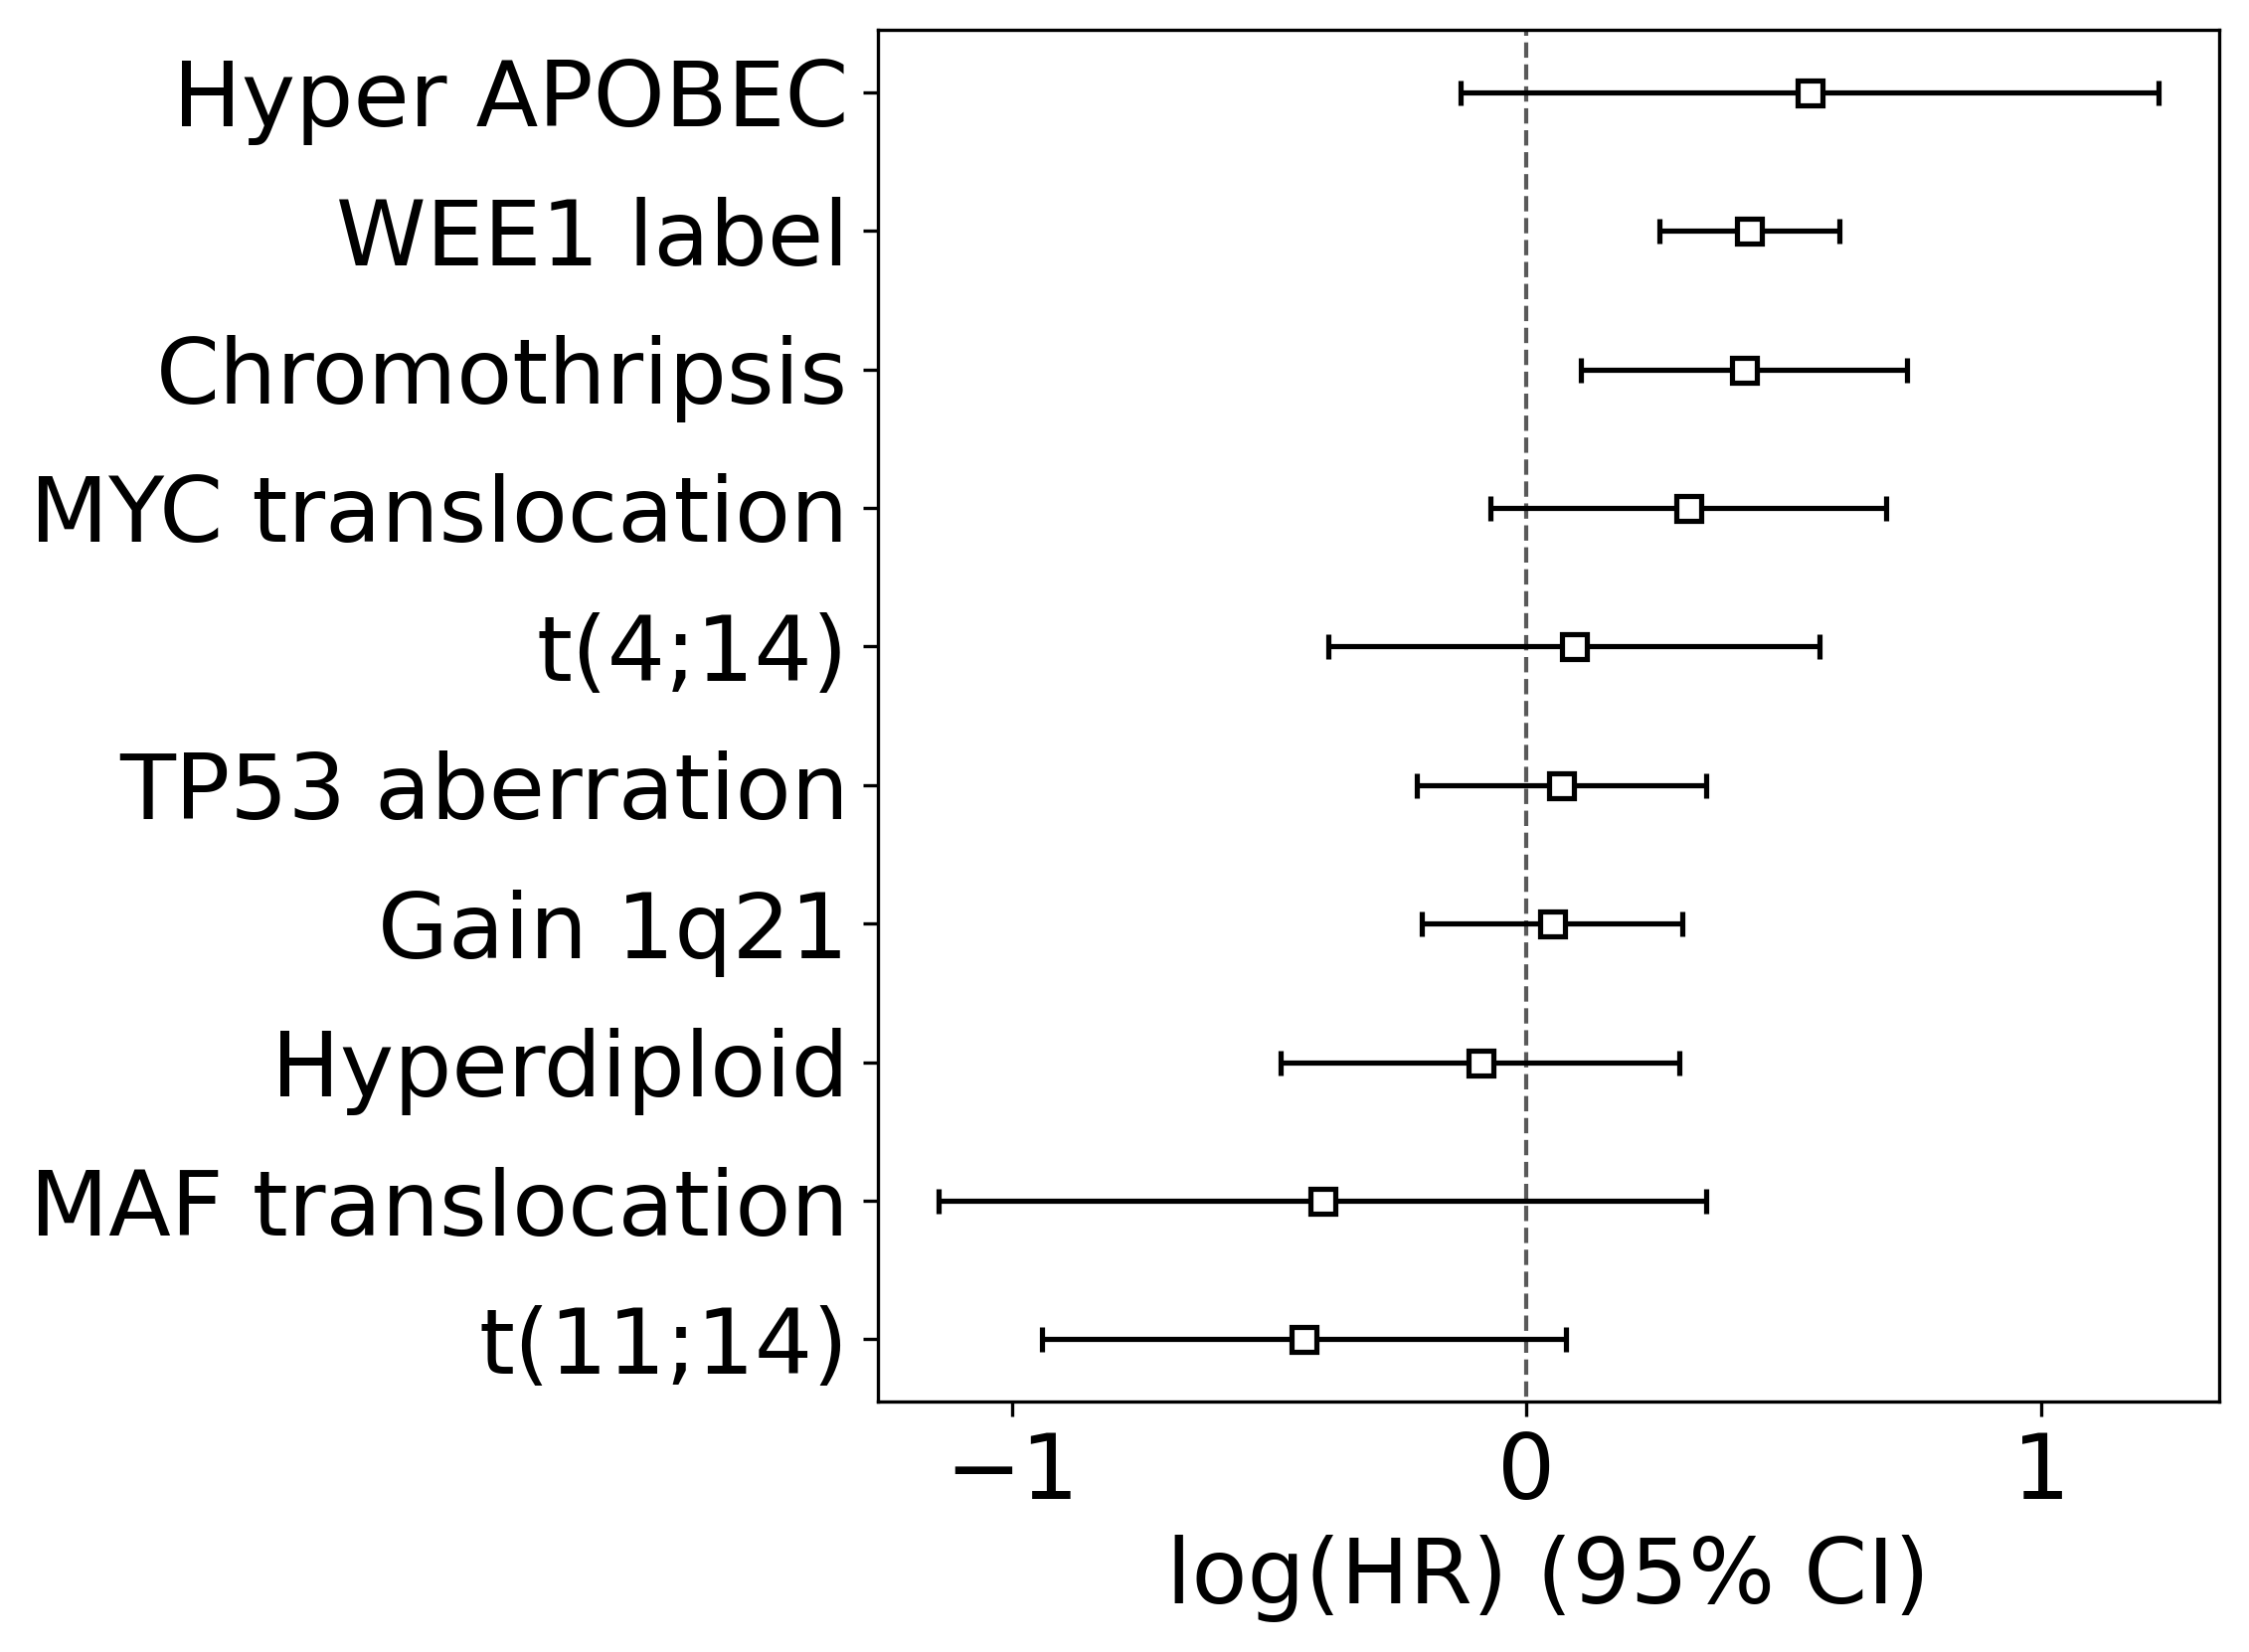

In [31]:
cph = CoxPHFitter()

cph.fit(secondary_dataset_df13[['WEE1 label', 'masked_censorlist', 'masked_event_duration',\
       'Hyperdiploid', 't(4;14)', 't(11;14)', 'MAF translocation', 'MYC translocation',\
       'Chromothripsis', 'Hyper APOBEC', 'TP53 aberration', 'Gain 1q21']],\
        duration_col='masked_event_duration', event_col='masked_censorlist')

plt.figure(dpi=300, figsize=(8, 6))
cph.plot()

plt.rcParams.update({'font.size': 22})

plt.tight_layout()
# plt.savefig('cph_all.png') 

In [32]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
WEE1 label,0.432502,1.541108,0.089109,0.257852,0.607152,1.294147,1.835197,0.0,4.853641,0.000001,19.654000
Hyperdiploid,-0.090559,0.913420,0.197817,-0.478274,0.297156,0.619852,1.346025,0.0,-0.457792,0.647102,0.627935
t(4;14),0.092027,1.096395,0.243661,-0.385539,0.569594,0.680084,1.767549,0.0,0.377685,0.705665,0.502946
t(11;14),-0.432903,0.648623,0.260155,-0.942798,0.076991,0.389536,1.080033,0.0,-1.664020,0.096108,3.379195
MAF translocation,-0.396847,0.672437,0.380693,-1.142992,0.349298,0.318863,1.418071,0.0,-1.042434,0.297211,1.750442
MYC translocation,0.313983,1.368866,0.196126,-0.070417,0.698382,0.932005,2.010498,0.0,1.600923,0.109394,3.192394
Chromothripsis,0.421741,1.524614,0.161593,0.105026,0.738457,1.110739,2.092703,0.0,2.609905,0.009057,6.786793
Hyper APOBEC,0.549157,1.731792,0.346125,-0.129236,1.227549,0.878767,3.412856,0.0,1.586585,0.112607,3.150637
TP53 aberration,0.067307,1.069624,0.143525,-0.213996,0.348610,0.807351,1.417096,0.0,0.468956,0.639101,0.645884


In [33]:
# cph.summary.to_excel('cph_all_risk.xlsx')

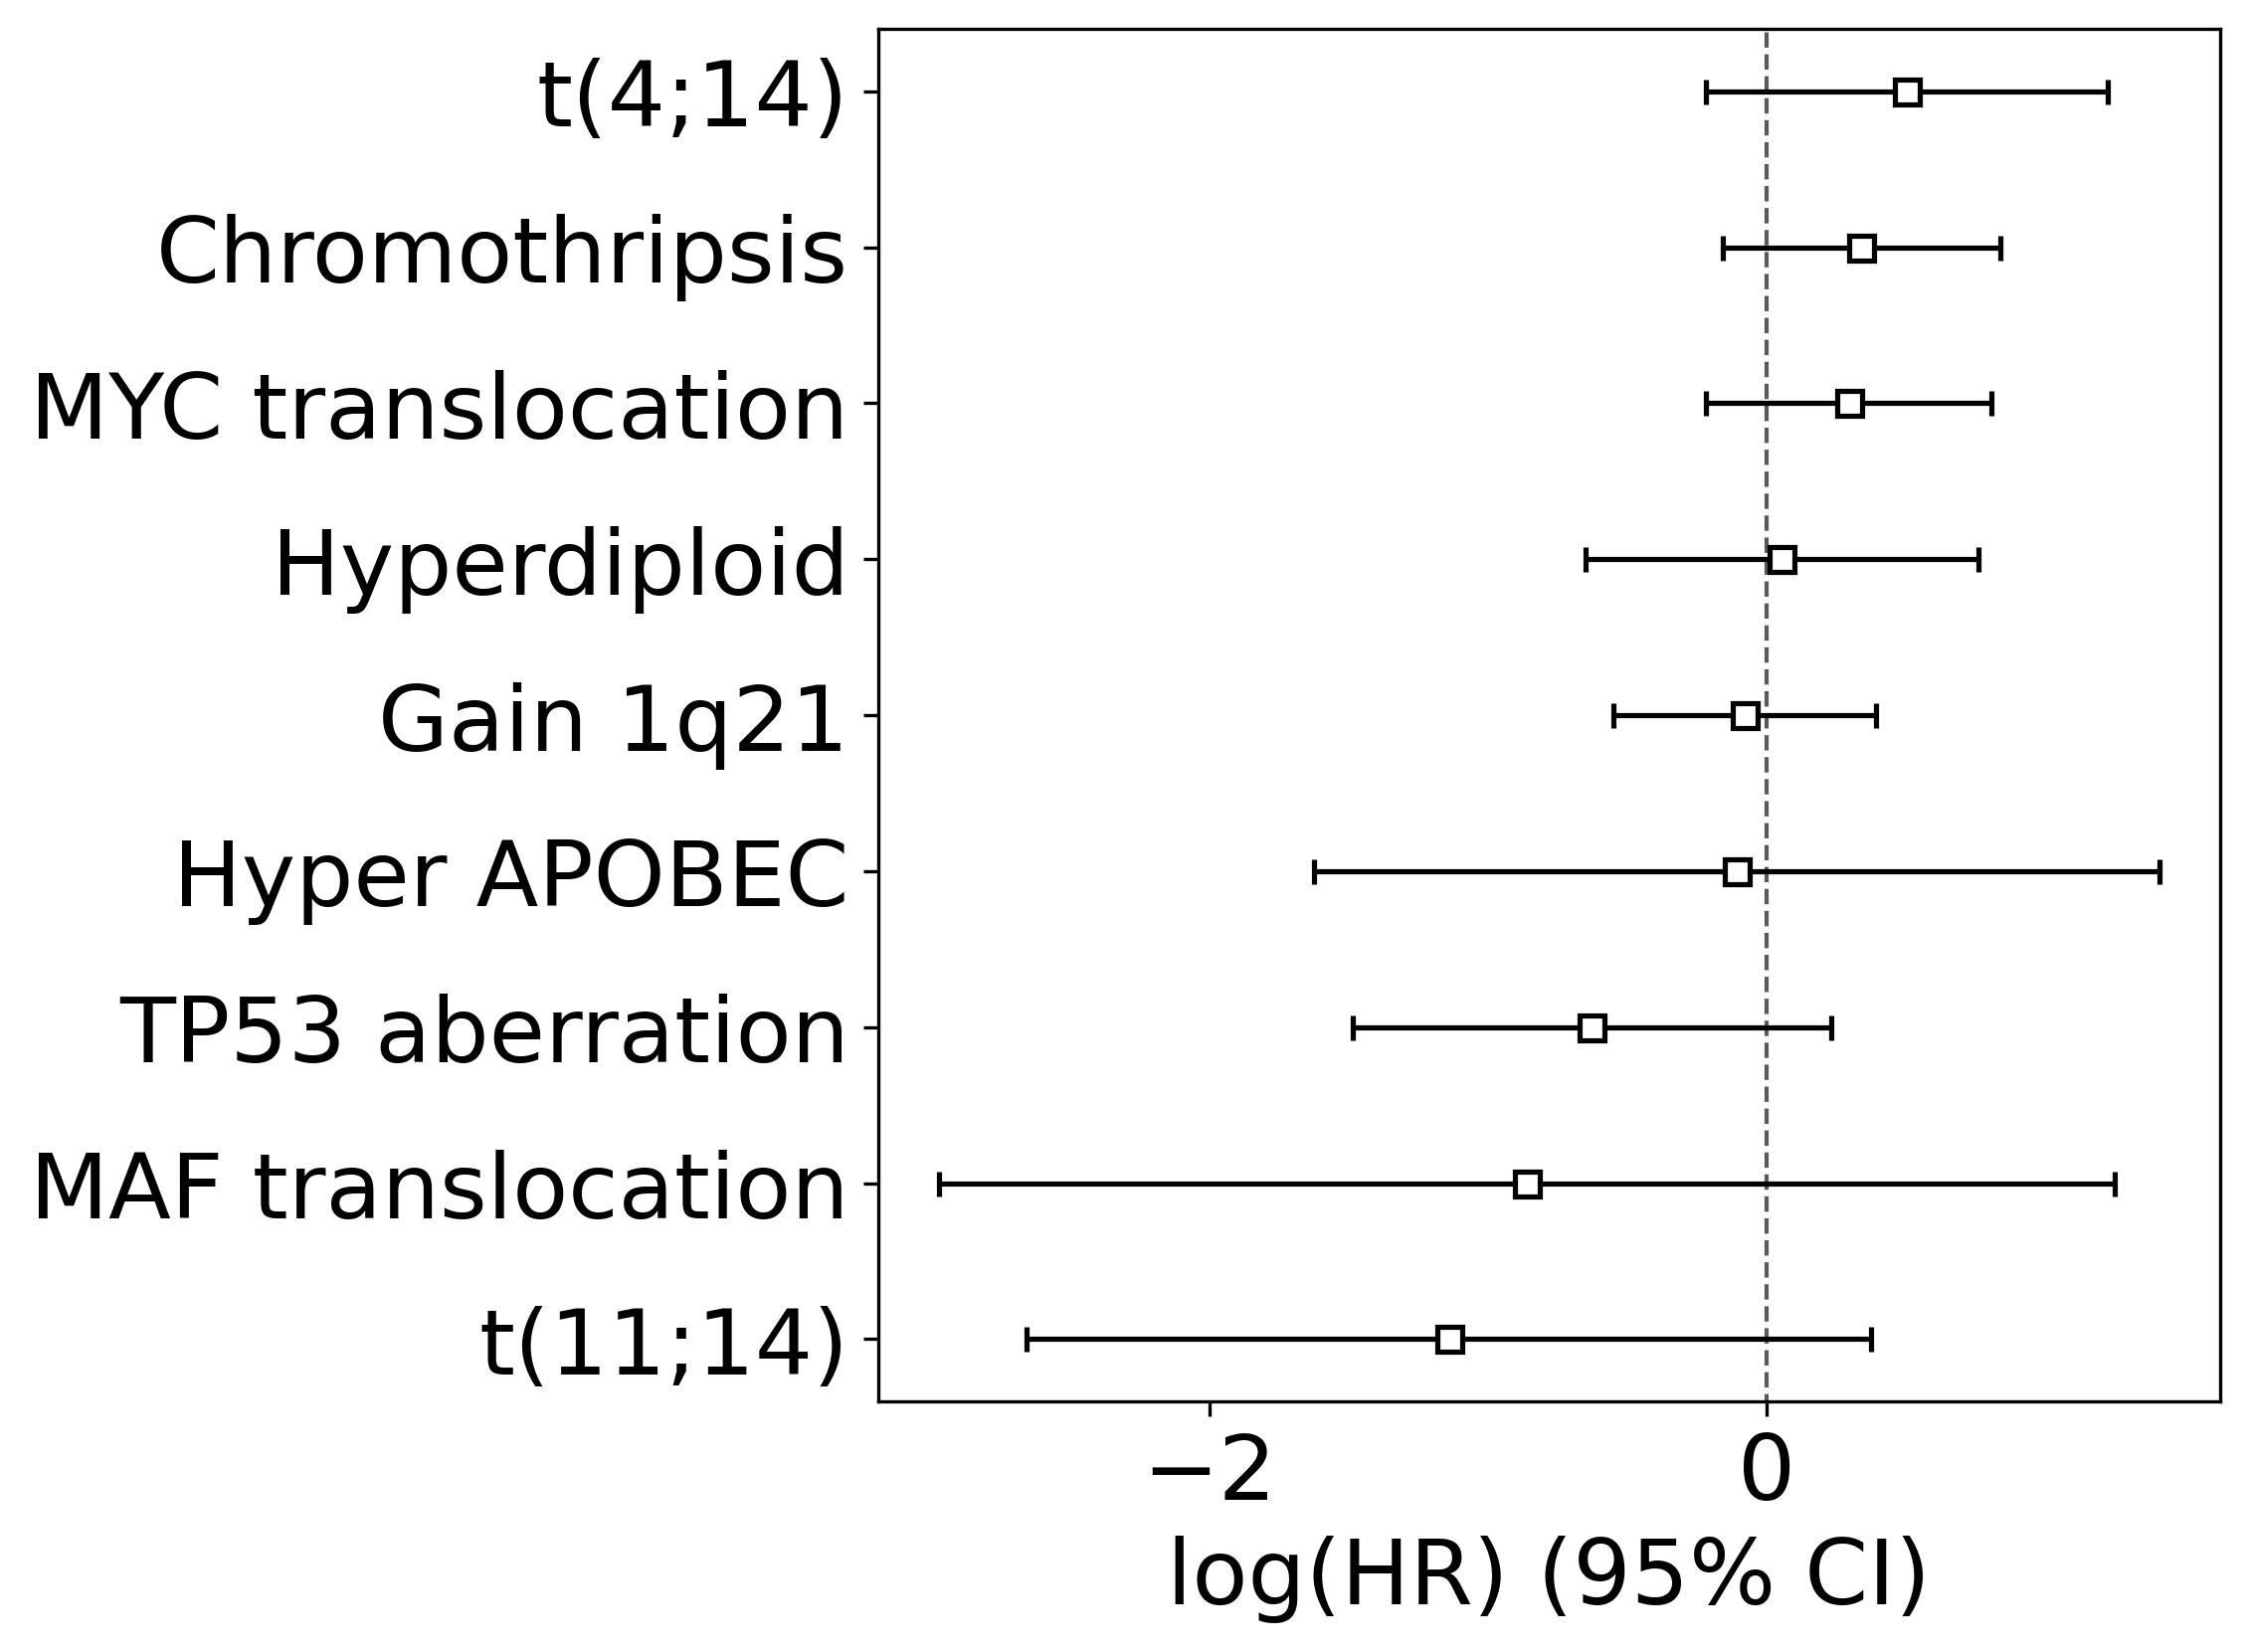

In [34]:
secondary_dataset_df2 = secondary_dataset_df[secondary_dataset_df['WEE1 label'].isin([1.0])]

cph = CoxPHFitter()
cph.fit(secondary_dataset_df2[['masked_censorlist', 'masked_event_duration',\
       'Hyperdiploid', 't(4;14)', 't(11;14)', 'MAF translocation', 'MYC translocation',\
       'Chromothripsis', 'Hyper APOBEC', 'TP53 aberration', 'Gain 1q21']],\
        duration_col='masked_event_duration', event_col='masked_censorlist')

plt.figure(dpi=300, figsize=(8, 6))
cph.plot()

plt.rcParams.update({'font.size': 22})

plt.tight_layout()
# plt.savefig('cph_low.png') 

In [35]:
cph.summary 

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Hyperdiploid,0.055795,1.057380,0.359873,-0.649544,0.761133,0.522284,2.140701,0.0,0.155039,0.876790,0.189696
t(4;14),0.504126,1.655537,0.367781,-0.216711,1.224963,0.805162,3.404039,0.0,1.370724,0.170461,2.552485
t(11;14),-1.139897,0.319852,0.773812,-2.656541,0.376747,0.070191,1.457535,0.0,-1.473093,0.140726,2.829039
MAF translocation,-0.860776,0.422834,1.076548,-2.970772,1.249221,0.051264,3.487624,0.0,-0.799570,0.423960,1.237999
MYC translocation,0.296130,1.344645,0.261072,-0.215562,0.807822,0.806088,2.243017,0.0,1.134284,0.256675,1.961983
Chromothripsis,0.341770,1.407437,0.253872,-0.155810,0.839351,0.855721,2.314864,0.0,1.346229,0.178229,2.488198
Hyper APOBEC,-0.106221,0.899226,0.773805,-1.622851,1.410409,0.197335,4.097630,0.0,-0.137271,0.890816,0.166800
TP53 aberration,-0.627158,0.534108,0.438040,-1.485700,0.231384,0.226344,1.260343,0.0,-1.431738,0.152219,2.715780
Gain 1q21,-0.076268,0.926568,0.240542,-0.547722,0.395186,0.578266,1.484660,0.0,-0.317068,0.751192,0.412746


In [36]:
# cph.summary.to_excel('cph_low_risk.xlsx')

In [37]:
secondary_dataset_df2

,WEE1 label,masked_censorlist,masked_event_duration,index,sample,Hyperdiploid,t(4;14),t(11;14),MAF translocation,MYC translocation,Chromothripsis,Hyper APOBEC,TP53 aberration,Gain 1q21
2,1,1,5.435616,2,MMRF_1030_1_BM,1.0,0.0,0.0,0,1.0,0,0.0,0.0,0.0
6,1,0,0.263014,6,MMRF_1037_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
9,1,0,7.380822,9,MMRF_1073_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
13,1,1,3.934247,13,MMRF_1092_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
14,1,0,7.668493,14,MMRF_1098_1_BM,0.0,0.0,1.0,0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,1,0,1.131507,552,MMRF_2702_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
559,1,0,0.391781,559,MMRF_2721_1_BM,1.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
561,1,0,1.032877,561,MMRF_2723_1_BM,1.0,0.0,0.0,0,1.0,0,0.0,0.0,0.0
563,1,0,0.002740,563,MMRF_2728_1_BM,1.0,0.0,0.0,0,0.0,1,0.0,0.0,0.0


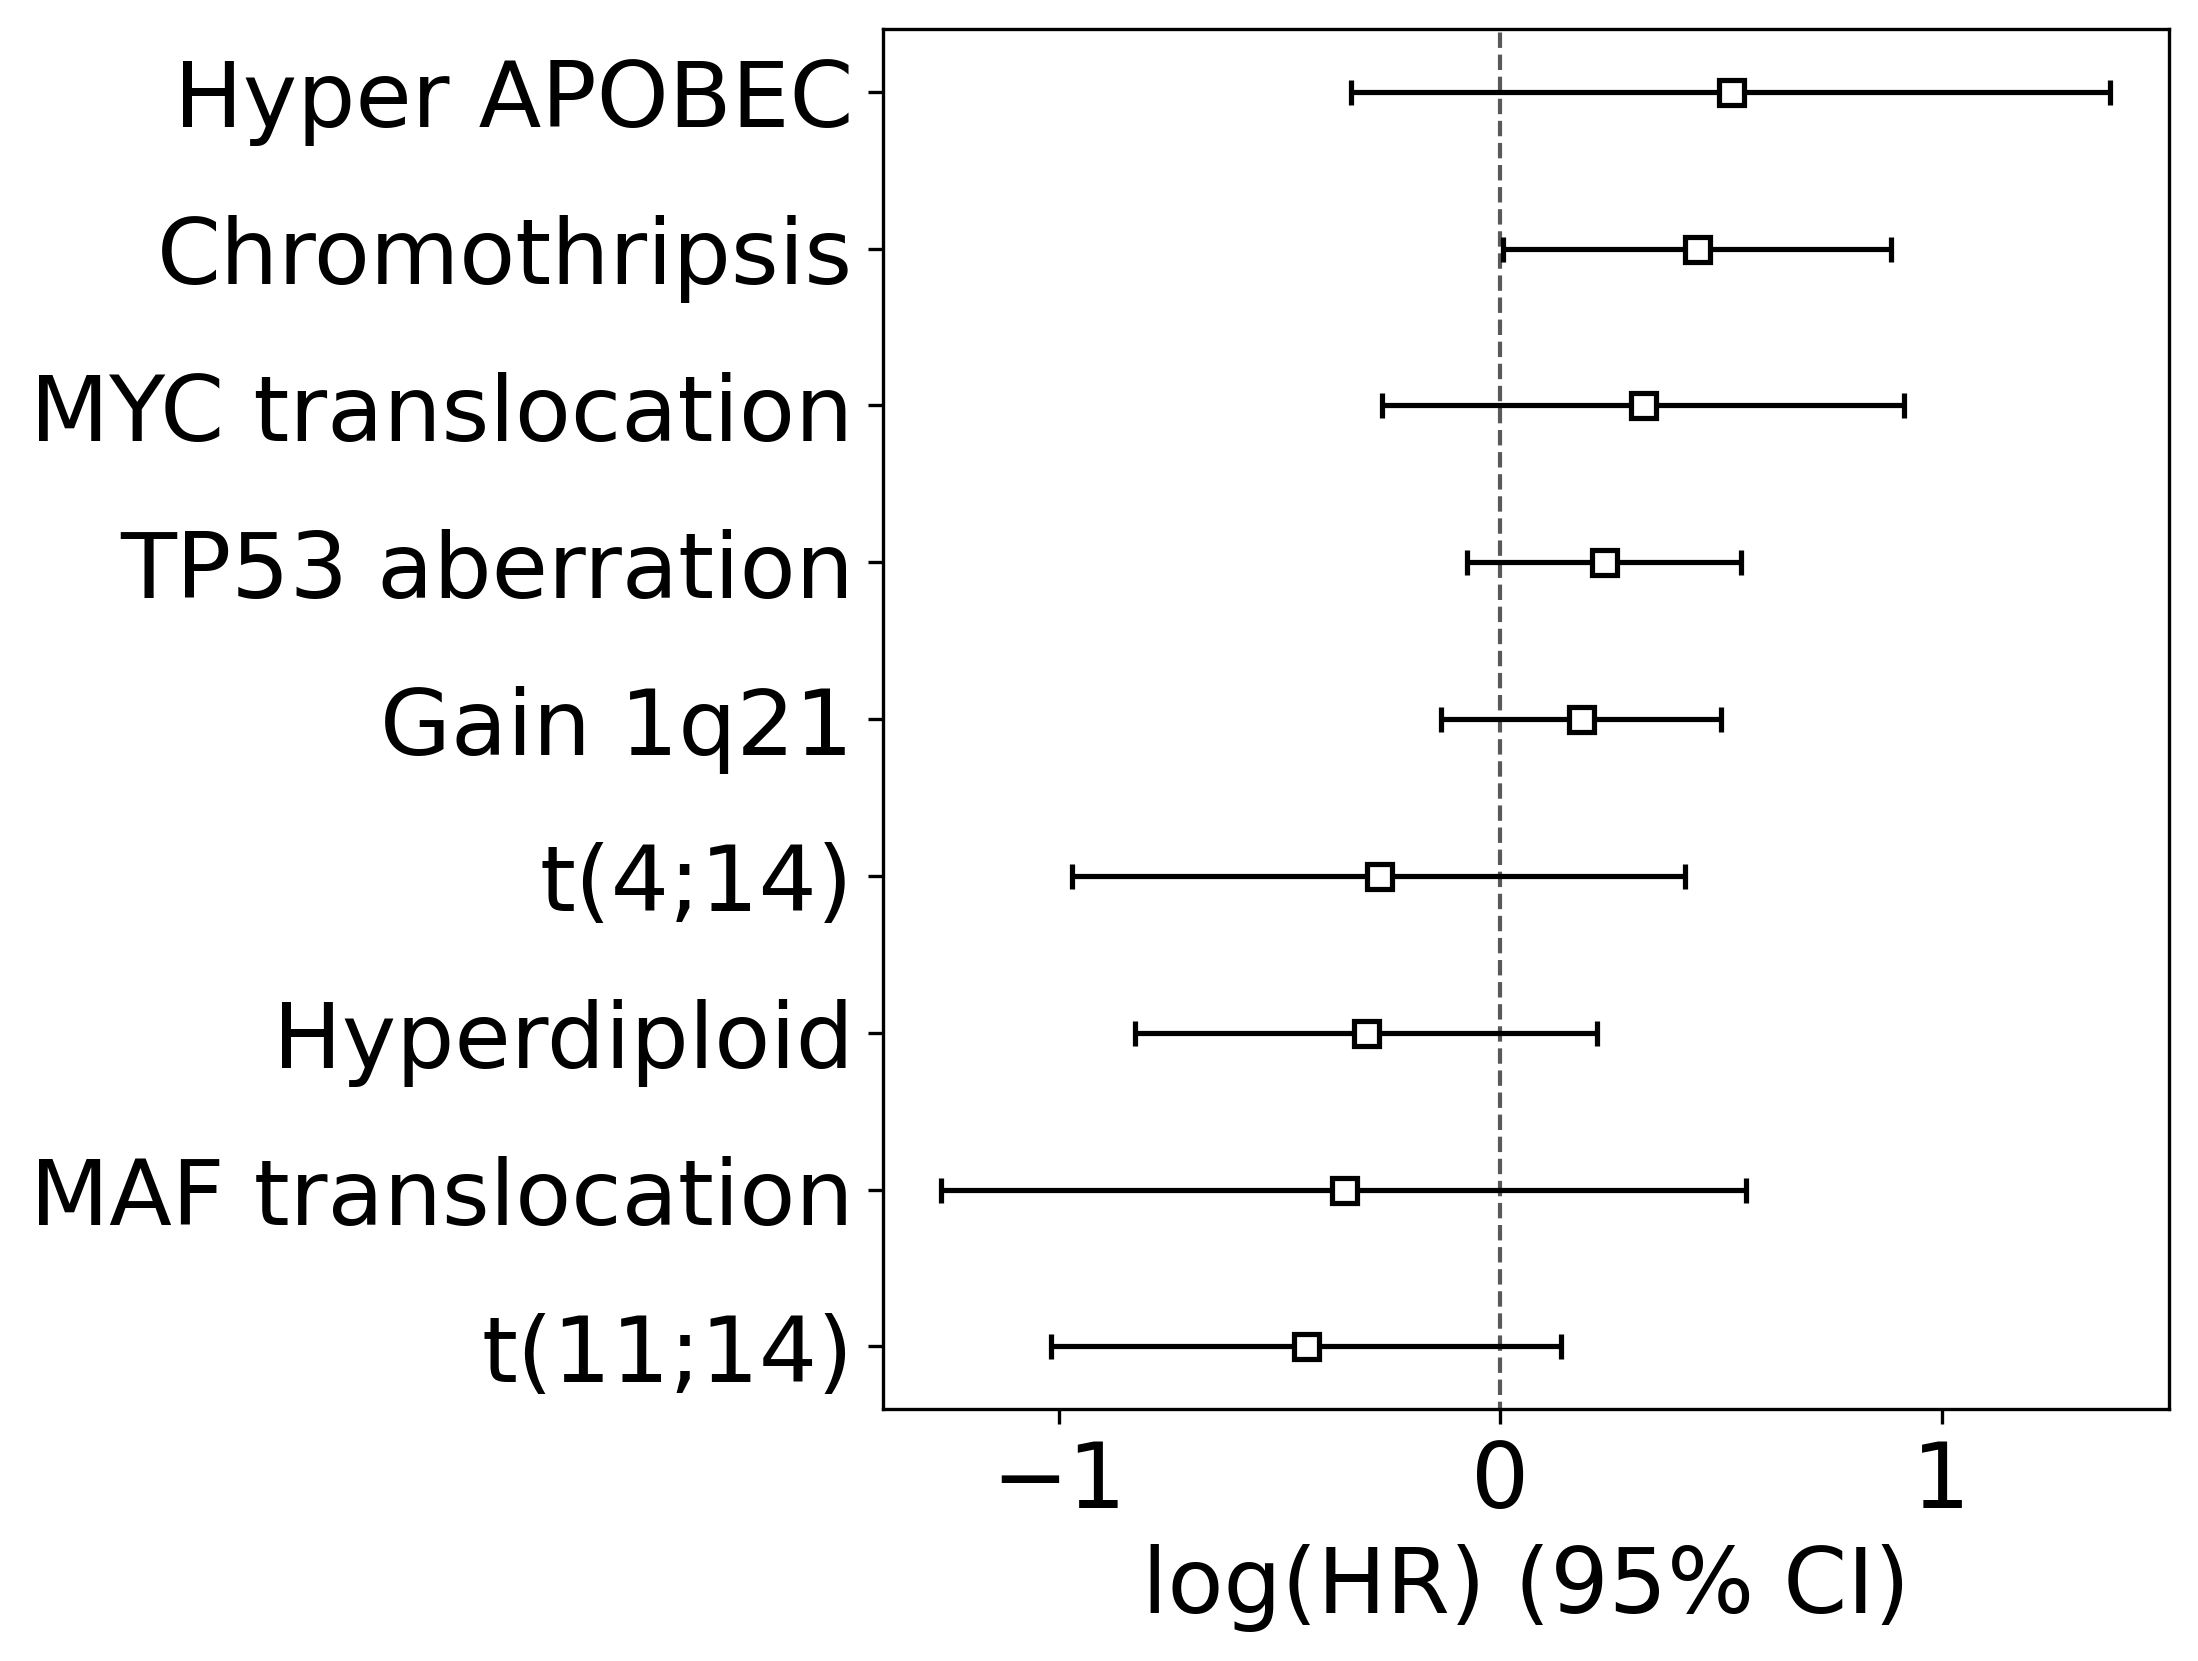

In [39]:
secondary_dataset_df2 = secondary_dataset_df[secondary_dataset_df['WEE1 label'].isin([3.0])]

cph = CoxPHFitter()
cph.fit(secondary_dataset_df2[['masked_censorlist', 'masked_event_duration',\
       'Hyperdiploid', 't(4;14)', 't(11;14)', 'MAF translocation', 'MYC translocation',\
       'Chromothripsis', 'Hyper APOBEC', 'TP53 aberration', 'Gain 1q21']],\
        duration_col='masked_event_duration', event_col='masked_censorlist')

plt.figure(dpi=300, figsize=(8, 6))
cph.plot()

plt.rcParams.update({'font.size': 22})

plt.tight_layout()
# plt.savefig('cph_high.png') 

In [40]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Hyperdiploid,-0.304529,0.737470,0.267617,-0.829050,0.219991,0.436464,1.246065,0.0,-1.137929,0.255150,1.970582
t(4;14),-0.275803,0.758963,0.354758,-0.971116,0.419510,0.378660,1.521216,0.0,-0.777439,0.436900,1.194626
t(11;14),-0.441480,0.643084,0.295034,-1.019736,0.136776,0.360690,1.146571,0.0,-1.496371,0.134557,2.893710
MAF translocation,-0.355636,0.700728,0.465410,-1.267823,0.556552,0.281444,1.744646,0.0,-0.764134,0.444787,1.168812
MYC translocation,0.323549,1.382023,0.302064,-0.268486,0.915583,0.764536,2.498231,0.0,1.071126,0.284113,1.815465
Chromothripsis,0.445291,1.560944,0.224616,0.005052,0.885530,1.005065,2.424268,0.0,1.982456,0.047428,4.398111
Hyper APOBEC,0.521935,1.685285,0.439316,-0.339108,1.382978,0.712405,3.986755,0.0,1.188063,0.234809,2.090442
TP53 aberration,0.235301,1.265290,0.158608,-0.075564,0.546166,0.927221,1.726621,0.0,1.483544,0.137930,2.857993
Gain 1q21,0.182320,1.199998,0.161861,-0.134922,0.499561,0.873784,1.647998,0.0,1.126397,0.259998,1.943429


In [41]:
# cph.summary.to_excel('cph_high_risk.xlsx')